# Transfer Learning avec divers modèles de classification pré-entraînés

Imports des bibliothèques pour le projet

In [ ]:
import time
import itertools
import os
import numpy as np
import pandas as pd
import sys

"""
plot de graphes
"""
import matplotlib.pyplot as plt

"""
Création et gestion des modèles de classification d'images avec Keras
"""
from tensorflow import keras

#Accès aux images à classifier, qui sont réparties dans différents dossiers
from keras.preprocessing.image import ImageDataGenerator

#Différents types de couches pour les CNN
from keras.layers import Flatten, Dense, Activation

#Création de l'architecture des modèles avec Model
from keras.models import Model 

#Gestion des arrêtes anticipés
from keras.callbacks import EarlyStopping

#Utilisation de modèles enregistrés
from keras.models import load_model

"""
Importation des modèles pré-entraînés
"""

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_vgg16

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as preprocess_vgg19

from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as preprocess_resnet50

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as preprocess_xception

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inception_resnet_v2

from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input as preprocess_mobilenet

from keras.applications.densenet import DenseNet121, DenseNet201
from keras.applications.densenet import preprocess_input as preprocess_densenet

from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.applications.nasnet import preprocess_input as preprocess_nasnet

"""
Mesures de performance des modèles avec Sklearn
"""
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set up : fonctions utiles et initialisation

In [ ]:
#infos du dataset
labels = os.listdir("./Garbage classification")
nClasses = len(labels) #6
inputFolder = "./Garbage_train_test_val"

#Hyper-paramètres
batch_size = 32
epochs_nb = 65

modelInputSize =   {"VGG16":             [224,224], #[width,height]
                    "VGG19":             [224,224],
                    "ResNet50":          [224,224],
                    "Xception":          [299,299],
                    "InceptionV3":       [299,299],
                    "InceptionResNetV2": [299,299],
                    "MobileNet":         [224,224],
                    "DenseNet121":       [224,224],
                    "DenseNet201":       [224,224],
                    "NASNetLarge":       [331,331],
                    "NASNetMobile":      [224,224]}

* **Gestion des différents modèles pré-entraînés**

In [ ]:
def modelSettings(modelName):

  img_width = modelInputSize[modelName][0]
  img_height = modelInputSize[modelName][1]

  if (modelName == "VGG16"):
    preprocessing = preprocess_vgg16

  elif (modelName == "VGG19"):
    preprocessing = preprocess_vgg19

  elif (modelName == "ResNet50"):
    preprocessing = preprocess_resnet50

  elif (modelName == "Xception"):
    preprocessing = preprocess_xception

  elif (modelName == "InceptionV3"):
    preprocessing = preprocess_inception_v3

  elif (modelName== "InceptionResNetV2"):
    preprocessing = preprocess_inception_resnet_v2

  elif (modelName == "MobileNet"):
    preprocessing = preprocess_mobilenet

  elif (modelName== "DenseNet121" or modelName== "DenseNet201"):
    preprocessing = preprocess_densenet
  
  elif (modelName== "NASNetLarge" or modelName== "NASNetMobile"):
    preprocessing = preprocess_nasnet

  else :
      print("Impossible : ce modèle ne fait pas partie des modèles importés pour ce projet.")
      sys.exit()

  return img_width, img_height, preprocessing


def makeGenerators(modelName, inputFolder, batch_size):

  img_width, img_height, preprocessing = modelSettings(modelName)
  input_shape = (img_width, img_height, 3)


  train_datagen = ImageDataGenerator( preprocessing_function = preprocessing,
                                      width_shift_range=0.2, 
                                      height_shift_range=0.2, 
                                      horizontal_flip=True, 
                                      vertical_flip=True,
                                      rotation_range = 90,
                                      brightness_range = [0.8, 1.2],
                                      zoom_range = [0.8, 1],
                                      fill_mode='nearest')
  test_datagen = ImageDataGenerator(preprocessing_function = preprocessing)

  train_generator = train_datagen.flow_from_directory(directory=r'./{}/train'.format(inputFolder),
                                                      target_size=(img_width, img_height),
                                                      color_mode='rgb',
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      shuffle=True,
                                                      seed=42)
  test_generator = test_datagen.flow_from_directory(directory=r'./{}/test'.format(inputFolder),
                                                    target_size=(img_width, img_height),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)
  validation_generator = test_datagen.flow_from_directory(directory=r'./{}/val'.format(inputFolder),
                                                          target_size=(img_width, img_height),
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='categorical',
                                                          shuffle=False)

  return input_shape, train_generator, test_generator, validation_generator


def Architecture(model, nClasses):
  
  #Partie convolutive : on garde les paramètres des couches convolutives
  for layer in model.layers:
    layer.trainable = False
    lastLayer = model.output

  x = Flatten()(lastLayer)

  #Partie classification : on ajoute une couche entièrement connectée ainsi que la dernière avec le bon nombre de classes
  #Seule cette partie sera entraînée par le modèle
  x = Dense(256)(x)
  x = Activation('relu')(x)
  x = Dense(nClasses)(x)
  x = Activation('softmax')(x)

  model = Model(model.input, x)

  return model

* **Etude des modèles**

In [ ]:
def plot_accuracy_loss(history):
    """
    Retourne 2 graphes : un qui présente l'accuracy sur les sets de train et validation et le deuxième avec la loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    #Accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    ax1.plot(range(len(accuracy)), accuracy, label='train')
    ax1.plot(range(len(val_accuracy)), val_accuracy, label='validation')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')

    #Loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.plot(range(len(loss)), loss, label='train')
    ax2.plot(range(len(val_loss)), val_loss, label='validation')
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Affiche la matrice de confusion du modèle sur les données de test
    """
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def study_model(model, classes, test_generator, executionTime, plot_cm=False):
    """
    Retourne des informations sur la performance du modèle
    """

    #Durée d'entraînement
    print(f"Durée d'entraînement : {round(executionTime, 2)} secondes")

    #Performances sur le set de test
    preds = model.predict(test_generator)  # preds are proba for each class
    preds_classes = [i.argmax() for i in preds]
    y_true = test_generator.classes
    acc_test = accuracy_score(y_true, preds_classes)
    prec_test = precision_score(y_true, preds_classes, average='weighted')
    rec_test = recall_score(y_true, preds_classes, average='weighted')
    f1_test = f1_score(y_true, preds_classes, average='weighted')
    results = pd.DataFrame([[acc_test, prec_test, rec_test, f1_test]], columns=['accuracy', 'precision', 'recall', 'f1-score'])
    print("\nPerformances sur le set de test : \n")
    print(results)

    #Matrice de confusion
    if (plot_cm):
      cm = confusion_matrix(y_true, preds_classes)
      plot_confusion_matrix(cm, classes)

# VGG19

Nous téléchargeons le modèle **VGG19 pré-entraîné sur ImageNet** et ne modifions que la partie classification (correspondant aux couches entièrements connectées). Les poids des couches convolutives de VGG19 sont donc conservées (layer.trainable = False).

In [ ]:
modelName = "VGG19"

input_shape, train_generator, test_generator, validation_generator =  makeGenerators(modelName, inputFolder, batch_size)
model = VGG19(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_vgg19 = Architecture(model, nClasses)
model_vgg19.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
startTime=time.time()
history = model_vgg19.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)

Epoch 1/65
56/56 [==============================] - 530s 9s/step - loss: 4.9077 - accuracy: 0.3958 - val_loss: 3.5087 - val_accuracy: 0.5358
Epoch 2/65
56/56 [==============================] - 43s 760ms/step - loss: 3.1605 - accuracy: 0.5476 - val_loss: 2.5698 - val_accuracy: 0.6127
Epoch 3/65
56/56 [==============================] - 41s 725ms/step - loss: 2.3546 - accuracy: 0.6138 - val_loss: 2.1348 - val_accuracy: 0.6631
Epoch 4/65
56/56 [==============================] - 40s 718ms/step - loss: 1.9221 - accuracy: 0.6676 - val_loss: 1.8578 - val_accuracy: 0.6684
Epoch 5/65
56/56 [==============================] - 40s 719ms/step - loss: 1.6147 - accuracy: 0.6852 - val_loss: 1.7494 - val_accuracy: 0.6817
Epoch 6/65
56/56 [==============================] - 40s 718ms/step - loss: 1.4694 - accuracy: 0.7089 - val_loss: 1.6508 - val_accuracy: 0.7003
Epoch 7/65
56/56 [==============================] - 40s 717ms/step - loss: 1.3359 - accuracy: 0.7282 - val_loss: 1.4812 - val_accuracy: 0.7162
E

In [ ]:
model_vgg19.save(f'./Modeles/{modelName}.h5')

In [ ]:
study_model(model_vgg19, labels, test_generator, executionTime)

Durée d'entraînement : 3123.99 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.822917   0.826353  0.822917  0.822247


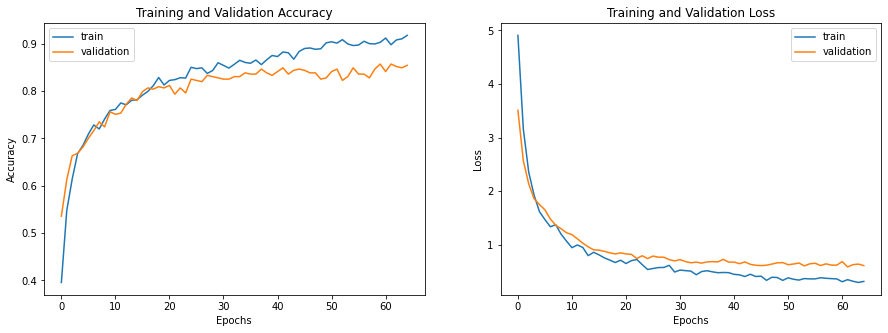

In [ ]:
plot_accuracy_loss(history)

Le modèle a-t-il convergé après 65 epochs ? Pas sûr

Il est préférable d'entraîner le modèle à nouveau sur quelques epochs.

In [ ]:
model_vgg19_2 = load_model(f"./Modeles/{modelName}.h5")
model_vgg19_2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
cb_list=[es]
epochs_nb = 35

In [ ]:
startTime=time.time()
history = model_vgg19_2.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator, callbacks=cb_list)
executionTime2 = (time.time() - startTime)

Epoch 1/35
56/56 [==============================] - 45s 773ms/step - loss: 0.3146 - accuracy: 0.9173 - val_loss: 0.6602 - val_accuracy: 0.8541
Epoch 2/35
56/56 [==============================] - 41s 748ms/step - loss: 0.2876 - accuracy: 0.9190 - val_loss: 0.6398 - val_accuracy: 0.8488
Epoch 3/35
56/56 [==============================] - 41s 732ms/step - loss: 0.3453 - accuracy: 0.9151 - val_loss: 0.6190 - val_accuracy: 0.8541
Epoch 4/35
56/56 [==============================] - 42s 746ms/step - loss: 0.2995 - accuracy: 0.9207 - val_loss: 0.6227 - val_accuracy: 0.8541
Epoch 5/35
56/56 [==============================] - 41s 727ms/step - loss: 0.2952 - accuracy: 0.9100 - val_loss: 0.6099 - val_accuracy: 0.8488
Epoch 6/35
56/56 [==============================] - 41s 748ms/step - loss: 0.3265 - accuracy: 0.9185 - val_loss: 0.5671 - val_accuracy: 0.8647
Epoch 7/35
56/56 [==============================] - 41s 728ms/step - loss: 0.2566 - accuracy: 0.9281 - val_loss: 0.6443 - val_accuracy: 0.8594

In [ ]:
model_vgg19_2.save(f'./Modeles/{modelName}2.h5')

In [ ]:
study_model(model_vgg19_2, labels, test_generator, executionTime2)

Durée d'entraînement : 660.5 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.825521   0.827939  0.825521  0.824667


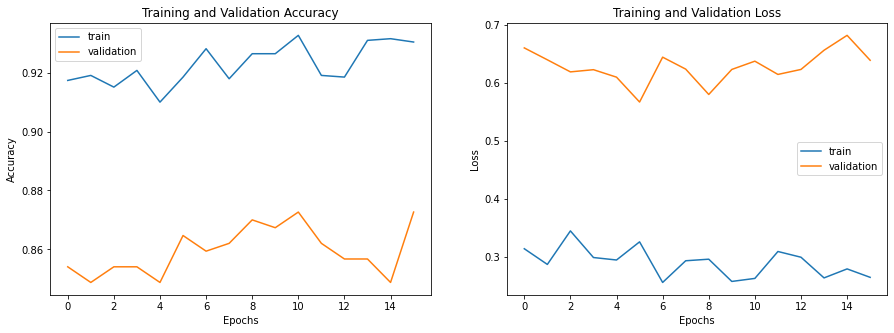

In [ ]:
plot_accuracy_loss(history)

Les résultats sur les sets d'entraînement et de validation ont légèrement augmenté (passant respectivement de 91 à 93% et de 85 à 87% d'accuracy). Cependant, les résultats sur le set de test ont à peine bougés : **82,5% d'accuracy**. Nous pouvons en conclure que le modèle avait bien convergé.

Les performances de VGG19 ne sont pas meilleures que celles de VGG16. De plus, le temps d'entraînement est plus long.

# ResNet50

In [ ]:
modelName = "ResNet50"
epochs_nb = 65

input_shape, train_generator, test_generator, validation_generator =  makeGenerators(modelName, inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50 = Architecture(model, nClasses)
model_resnet50.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50.save(f'./Modeles/{modelName}.h5')

Epoch 1/65
56/56 [==============================] - 48s 774ms/step - loss: 1.2637 - accuracy: 0.6212 - val_loss: 0.6737 - val_accuracy: 0.7560
Epoch 2/65
56/56 [==============================] - 40s 705ms/step - loss: 0.7157 - accuracy: 0.7639 - val_loss: 0.5755 - val_accuracy: 0.8170
Epoch 3/65
56/56 [==============================] - 40s 717ms/step - loss: 0.5495 - accuracy: 0.7984 - val_loss: 0.4457 - val_accuracy: 0.8515
Epoch 4/65
56/56 [==============================] - 39s 699ms/step - loss: 0.5154 - accuracy: 0.8347 - val_loss: 0.5979 - val_accuracy: 0.8302
Epoch 5/65
56/56 [==============================] - 40s 713ms/step - loss: 0.4391 - accuracy: 0.8505 - val_loss: 0.4202 - val_accuracy: 0.8594
Epoch 6/65
56/56 [==============================] - 39s 701ms/step - loss: 0.4320 - accuracy: 0.8613 - val_loss: 0.4260 - val_accuracy: 0.8753
Epoch 7/65
56/56 [==============================] - 39s 702ms/step - loss: 0.3394 - accuracy: 0.8884 - val_loss: 0.4386 - val_accuracy: 0.8727

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
study_model(model_resnet50, labels, test_generator, executionTime)

Durée d'entraînement : 2592 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.885417   0.887026  0.885417  0.884463


Les performances de ResNet50 surpassent largement celles de VGG16 et VGG19 car nous arrivons à une **accuracy de 88,5%** (contre 83% et 82,5%).

# Xception

In [ ]:
modelName = "Xception"
epochs_nb = 65

input_shape, train_generator, test_generator, validation_generator =  makeGenerators(modelName, inputFolder, batch_size)
model = Xception(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_xception = Architecture(model, nClasses)
model_xception.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
startTime=time.time()
history = model_xception.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_xception.save(f'./Modeles/{modelName}.h5')

Epoch 1/65
56/56 [==============================] - 451s 8s/step - loss: 0.8667 - accuracy: 0.6971 - val_loss: 0.5361 - val_accuracy: 0.8090
Epoch 2/65
56/56 [==============================] - 69s 1s/step - loss: 0.5406 - accuracy: 0.8024 - val_loss: 0.4174 - val_accuracy: 0.8541
Epoch 3/65
56/56 [==============================] - 70s 1s/step - loss: 0.4489 - accuracy: 0.8409 - val_loss: 0.4657 - val_accuracy: 0.8515
Epoch 4/65
56/56 [==============================] - 68s 1s/step - loss: 0.4267 - accuracy: 0.8460 - val_loss: 0.4083 - val_accuracy: 0.8674
Epoch 5/65
56/56 [==============================] - 68s 1s/step - loss: 0.3474 - accuracy: 0.8681 - val_loss: 0.5582 - val_accuracy: 0.8276
Epoch 6/65
56/56 [==============================] - 68s 1s/step - loss: 0.3323 - accuracy: 0.8845 - val_loss: 0.4224 - val_accuracy: 0.8488
Epoch 7/65
56/56 [==============================] - 68s 1s/step - loss: 0.3390 - accuracy: 0.8918 - val_loss: 0.4507 - val_accuracy: 0.8621
Epoch 8/65
56/56 [=

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
study_model(model_xception, labels, test_generator, executionTime)

Durée d'entraînement : 4824.38 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.869792    0.86912  0.869792   0.86805


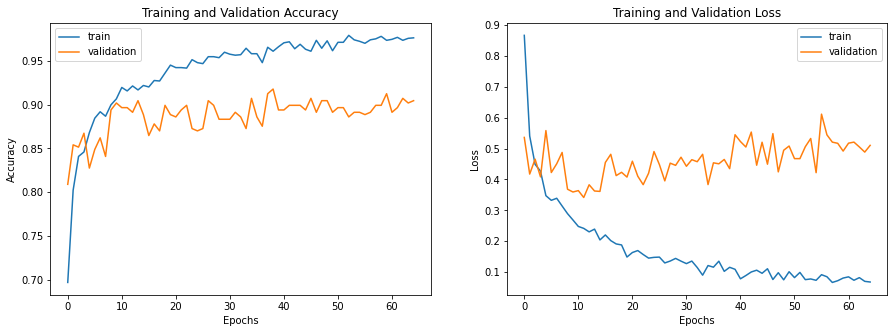

In [ ]:
plot_accuracy_loss(history)

L'accuracy atteint presque les 87%.

In [ ]:
#change working directory to save the files
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/Centrale-A5 Deep Learning/Projet_tutos/Garbage

/content/drive/My Drive/Centrale-A5 Deep Learning/Projet_tutos/Garbage


In [ ]:
%cd /content/drive/My\ Drive/Garbage

/content/drive/.shortcut-targets-by-id/1YUU_BfxIcyKet1fbcy82Pc3_Q_12H8ux/Garbage
